In [1]:
import os
import glob
import shutil

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

#from pathlib import Path


In [2]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

def label_figure(fig, data_identifier):                                                                                                                                     
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)    

In [3]:
%matplotlib notebook

# Set source dirs

In [4]:
home_dir = '/n/coxfs01/julianarhee/face-tracking'
project = 'facetracking-jyr-2020-01-25' #'sideface-jyr-2020-01-09'
project_dir = os.path.join(home_dir, project)
video_dir = os.path.join(home_dir, project, 'videos')

In [5]:
rootdir = '/n/coxfs01/2p-data'
eyetracker_dir = os.path.join(rootdir, 'eyetracker_tmp')

In [6]:
analysis_dir = os.path.join(project_dir, 'pose-analysis') # DLC analysis output dir

# Network info

In [7]:

projectid = 'facetrackingJan25'
project_dir = os.path.join(home_dir, project)

scorer='DLC_resnet50'
iteration = 1
shuffle = 1
trainingsetindex=0
videotype='.mp4'

snapshot = 391800 #430200 #20900


DLCscorer = '%s_%sshuffle%i_%i' % (scorer, projectid, shuffle, snapshot)
print("Extracting results from scorer: %s" % DLCscorer)

Extracting results from scorer: DLC_resnet50_facetrackingJan25shuffle1_391800


In [8]:
glob.glob(os.path.join(project_dir, 'dlc-models', 'iteration-%i' % iteration,\
                      '%s-trainset95shuffle%i' % (projectid, shuffle), 'train', 'snapshot-*.meta'))


['/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391500.meta',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391400.meta',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391600.meta',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391700.meta',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391800.meta']

# Get aggregate data

In [114]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)


/n/coxfs01/julianarhee/aggregate-visual-areas


# Select data sets where we have DLC data

In [115]:

#excl_sessions = ['20190607']

#incl_sessions = [s for s in incl_sessions if s not in excl_sessions]

#dsets = dsets[dsets['session'].isin(incl_sessions)]

In [116]:
incl_skeys = list(set([os.path.split(f)[-1].split('_f')[0] for f in glob.glob(os.path.join(analysis_dir, '*.h5'))]))

incl_sessions = ['_'.join(s.split('_')[0:2]) for s in incl_skeys]


In [117]:
incl_ixs = [i for i in sdata.index.tolist() if '_'.join([sdata.loc[i]['session'], sdata.loc[i]['animalid']]) in incl_sessions]

In [118]:
dsets = sdata.iloc[incl_ixs]

In [120]:
fovnums = [int(fv.split('_')[0][3:]) for fv in dsets['fov']]
dsets['fovnum'] = fovnums


In [121]:
dsets.groupby(['visual_area']).count()


,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,45,45,45,45,45
Lm,39,39,39,39,39
V1,40,40,40,40,40


In [122]:
dsets[dsets['session']=='20190607']

,animalid,experiment,fov,session,visual_area,fovnum
20,JC091,rfs10,FOV1_zoom2p0x,20190607,Li,1
21,JC091,gratings,FOV1_zoom2p0x,20190607,Li,1
22,JC091,blobs,FOV1_zoom2p0x,20190607,Li,1
23,JC091,retino,FOV1_zoom2p0x,20190607,Li,1


# Functions

In [23]:
# class struct():
#     pass

# import scipy.stats as spstats
# import json
# from pipeline.python.classifications import experiment_classes as util

# Load data

In [ ]:
from pipeline.python.classifications import rf_utils as rfutils

In [668]:
def load_traces(animalid, session, fovnum, curr_exp, traceid='traces001',
               responsive_test='ROC', responsive_thr=0.05, response_type='dff'):
    
    # Load experiment neural data
    fov = 'FOV%i_zoom2p0x' % fovnum
    exp = util.Objects(animalid, session, fov, traceid=traceid)
    exp.load(trace_type='dff', update_self=True, make_equal=False)
    labels = exp.data.labels.copy()

    # Get stimulus config info
    sdf = exp.data.sdf
    sdf = reformat_morph_values(sdf)
    n_conditions = len(sdf['size'].unique())
    color_list = sns.color_palette('cubehelix', n_conditions)
    cond_colors = dict((k, color_list[i]) for i, k in enumerate(sorted(sdf['size'].unique()))) #.keys()))

    # Get responsive cells
    responsive_cells, ncells_total = exp.get_responsive_cells(response_type=response_type,\
                                                              responsive_test=responsive_test,
                                                              responsive_thr=responsive_thr)
    
    traces = exp.data.traces[responsive_cells]

    return traces, labels, sdf
    
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [715]:
def traces_to_trials(traces, labels):
    '''
    Returns dataframe w/ columns = roi ids, rows = mean response to stim ON per trial
    Last column is config on given trial.
    '''
    s_on = int(labels['stim_on_frame'].mean())
    n_on = int(labels['nframes_on'].mean())

    roi_list = traces.columns.tolist()
    trial_list = np.array([int(trial[5:]) for trial, g in labels.groupby(['trial'])])
    mean_responses = pd.DataFrame(np.vstack([np.nanmean(traces.iloc[g.index[s_on:s_on+n_on]], axis=0)\
                                        for trial, g in labels.groupby(['trial'])]),
                                         columns=roi_list, index=trial_list)

    condition_on_trial = np.array([g['config'].unique()[0] for trial, g in labels.groupby(['trial'])])
    mean_responses['config'] = condition_on_trial

    return mean_responses


In [153]:
# Select response filters
responsive_test='ROC'
responsive_thr = 0.05
response_type = 'dff'


In [129]:
dsets[(dsets['animalid']==animalid) & (dsets['session']==session)]

,animalid,experiment,fov,session,visual_area,fovnum
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,1
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,1
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,1


# First load or create blob data

In [163]:
always_exclude = ['20190426_JC078']


In [159]:
load_data = False
data_dir = os.path.join(aggregate_dir, 'data-stats')
stats_id = 'blobs_%s-%s_%s-thr-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
print(stats_id)
blobsdata_outfile = os.path.join(data_dir, '%s.pkl' % stats_id)
print("BLOBS: data from -- %s" % blobsdata_outfile)

if os.path.exists(blobsdata_outfile):
    with open(blobsdata_outfile, 'rb') as f:
        DATA = pkl.load(f)
else:
    load_data = True

blobs_traces001-dff_ROC-thr-0.05
BLOBS: data from -- /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-dff_ROC-thr-0.05.pkl


In [845]:
load_data
blobsdata_outfile

'/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-dff_ROC-thr-0.05.pkl'

In [ ]:
if load_data:
    dsets = sdata[sdata['experiment']=='blobs']
    #print(dsets.shape)
    fovnums = [int(fv.split('_')[0][3:]) for fv in dsets['fov']]
    dsets['fovnum'] = fovnums

    DATA = {}
    curr_exp = 'blobs'
    for (animalid, session, fovnum), g in dsets.groupby(['animalid', 'session', 'fovnum']):

        datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
        
        if '%s_%s' % (session, animalid) in always_exclude:
            continue

        # Load traces
        traces, labels, sdf = load_traces(animalid, session, fovnum, curr_exp, 
                                          traceid=traceid, response_type=response_type,
                                          responsive_test=responsive_test, responsive_thr=responsive_thr)
        # Calculate mean trial metric
        mean_responses = traces_to_trials(traces, labels)

        DATA['%s' % datakey] = {'data': mean_responses,
                                'sdf': sdf}
        
    # Save
    with open(blobsdata_outfile, 'wb') as f:
        pkl.dump(DATA, f, protocol=pkl.HIGHEST_PROTOCOL)
    print("Done!")
    

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/data_arrays/np_subtracted.npz
NP_subtracted offset was: 58.87
adding NP offset... (NP baseline offset: 289.30)
((249000, 300), (300,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/summary_stats/ROC/roc_results.pkl']
... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blob

In [166]:
len(DATA.keys())

36

In [170]:
blob_dsets = sdata[sdata['experiment']=='blobs']
blob_dsets.shape

(37, 5)

In [171]:
rf_dsets = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
rf_dsets.shape

(71, 5)

# Select datasets where we have objects + RFs

In [172]:
include_sessions = []
included_ixs = []
for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
    if any(['rf' in v for v in g['experiment'].values]) and 'blobs' in g['experiment'].values:
        include_sessions.append((animalid, session, fov))
        included_ixs.extend(g.index.tolist())
        
dsets = sdata.loc[included_ixs]
fovnums = [int(fv.split('_')[0][3:]) for fv in dsets['fov']]
dsets['fovnum'] = fovnums

print(dsets.shape)

(137, 6)


In [174]:
print('blobs', dsets[dsets['experiment']=='blobs'].shape)
print('RFs', dsets[dsets['experiment'].isin(['rfs', 'rfs10'])].shape)

('blobs', (36, 6))
('RFs', (41, 6))


In [175]:
dsets.groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,51,51,51,51,51
Lm,42,42,42,42,42
V1,44,44,44,44,44


# Get RF luminance info

In [179]:
stimulus_dir = '/home/julianarhee/Repositories/protocols/physiology/stimuli/images'

load_data = False
data_dir = os.path.join(aggregate_dir, 'data-stats')
stats_id = 'rf-luminances_%s-%s_blobs' % (traceid, response_type)
print(stats_id)
rfsdata_outfile = os.path.join(data_dir, '%s.pkl' % stats_id)
print("Receptive Fields: data from -- %s" % rfsdata_outfile)

if os.path.exists(rfsdata_outfile):
    with open(rfsdata_outfile, 'rb') as f:
        RFDATA = pkl.load(f)
else:
    load_data = True

rf-luminances_traces001-dff_blobs
Receptive Fields: data from -- /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/rf-luminances_traces001-dff_blobs.pkl


In [180]:
#load_data

True

In [207]:
if load_data:
    rf_dsets = dsets[dsets['experiment'].isin(['rfs', 'rfs10'])]
    print(rf_dsets.shape)

    RFDATA = {}
    for (animalid, session, fovnum, curr_exp), g in rf_dsets.groupby(['animalid', 'session', 'fovnum', 'experiment']):
        datakey = '%s_%s_fov%i_%s' % (session, animalid, fovnum, curr_exp)
        rflum_df = rfutils.get_rf_luminances(animalid, session, fovnum, curr_exp, 
                                             traceid=traceid, response_type=response_type,
                                             stimulus_dir=stimulus_dir)
        RFDATA[datakey] = rflum_df
        
    # Save
    with open(rfsdata_outfile, 'wb') as f:
        pkl.dump(RFDATA, f, protocol=pkl.HIGHEST_PROTOCOL)
    print("Done!")

(41, 6)
9 images found for 9 objects
[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC076|20190420] No experiment exists for: gratings
Stimuli presented at coords: (30, 5)
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus inf

... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC078|20190513|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
102 rois.
('Non image conditions:', [-1])
9 images found for 9 objects
[JC080] 20190506 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC080|20190506] No experiment exists for: gratings
Stimuli presented at coords: (15, 8)
... [JC080|20190506|FOV1_zoom2p0x] creating gratings object
GET

9 images found for 9 objects
[JC083] 20190517 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190517 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC083|20190517|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC083|20190517|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, 8)
... [JC083|20190517|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got 

... got rf fits
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
93 rois.
('Non image conditions:', [-1])
9 images found for 9 objects
[JC091] 20190602 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC091|20190602|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, -8)
... [JC091|20190602|FOV1_zoom

Stimuli presented at coords: (25, 5)
... [JC097|20190613|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC097|20190613|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
153 rois.
('Non image conditions:', [-1])
9 images found for 9 objects
[JC097] 20190613 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC097|20190613|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... 

... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (25, -5)
... [JC099|20190617|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC099|20190617|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
30 rois.
('Non image conditions:', [-1])
9 images found for 9 objects
[JC110] 20191006 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC110|20191006|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name

# Load pupil data

In [716]:
state_dir = os.path.join(aggregate_dir, 'behavior-state')

snapshot = 391800

pupildata_outfile = os.path.join(state_dir, 'blobs_pupil_snapshot-%i.pkl' % (snapshot))
print(pupildata_outfile)
assert os.path.exists(pupildata_outfile), "Pupil data not found (snapshot: %i)" % snapshot

print("...loading data")
with open(pupildata_outfile, 'rb') as f:
    PUPILDATA = pkl.load(f)


/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/blobs_pupil_snapshot-391800.pkl
...loading data


# Test 1 dataset

#### Test w/ 1 dataset

In [814]:

# # Select a dataset to test
# animalid = 'JC084'
# session = '20190522'
# fovnum = 1 #'FOV1_zoom2p0x'
# traceid = 'traces001'

# Select a dataset to test
animalid = 'JC099'
session = '20190609'
fovnum = 1 #'FOV1_zoom2p0x'
traceid = 'traces001'

# # Select a dataset to test
# animalid = 'JC091'
# session = '20190606'
# fovnum = 1 #'FOV1_zoom2p0x'
# traceid = 'traces001'

In [815]:
# traces, labels, sdf = load_traces(animalid, session, fovnum, curr_exp, traceid=traceid, response_type=response_type,
#                                   responsive_test=responsive_test, responsive_thr=responsive_thr)

# mean_responses = traces_to_trials(traces, labels)


In [816]:
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
print(datakey)

# OBJECT data and info
mean_responses = DATA[datakey]['data'].copy()
sdf = DATA[datakey]['sdf'].copy()
rois_objects = mean_responses.columns.tolist()
sizes = sorted(DATA[datakey]['sdf']['size'].unique())

# RF data and info
rf_keys = [k for k in RFDATA.keys() if datakey in k]
if any('rfs10' in r for r in rf_keys):
    rf_key = '%s_rfs10' % datakey
else:
    rf_key = '%s_rfs' % datakey
rf_luminances = RFDATA[rf_key].copy()
rf_cfgs=[]
for sz, mp in zip(rf_luminances['size'], rf_luminances['object']):
    morphlevel = -1 if mp=='fullscreen' else int(mp[1:])
    curr_config = sdf[(sdf['size']==sz) & (sdf['morphlevel']==morphlevel)].index.tolist()[0]
    rf_cfgs.append(curr_config)
rf_luminances['config'] = rf_cfgs

rois_rfs = sorted(rf_luminances['rid'].unique())

# Get ROIs for both
print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
roi_list = np.intersect1d(rois_objects, rois_rfs)
roi_list = [int(i) for i in roi_list]
print("%i rois common to both." % len(roi_list))



20190609_JC099_fov1
Blobs: 63, RFs: 70
28 rois common to both.


## Simple glm

In [817]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer, quantile_transform
#from sklearn.compose import TransformedTargetRegressor
import sklearn.metrics as skmetrics #import median_absolute_error, r2_score



# Classify 'neural types'

In [818]:
neuraltypes_dir = os.path.join(aggregate_dir, 'behavior-state', 'neural-types')
if not os.path.exists(neuraltypes_dir):
    os.makedirs(neuraltypes_dir)
print(neuraltypes_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/neural-types


In [819]:

def get_sample_data(rid, rf_luminances, mean_responses, *args):
    
    tmprf = rf_luminances[(rf_luminances['rid']==rid)].copy()
    xx = [np.array([float(tmprf[tmprf['config']==cfg]['RF_luminance'].values) \
                   for cfg in mean_responses['config']])]
    
    for arg in args:
        xx.append(arg)
    #print("Using %i regressors" % len(xx))
    regressor_placeholders = ['x%i' % i for i in np.arange(0, len(xx))]
        
    Xs = pd.DataFrame(np.vstack(xx).T, columns=regressor_placeholders)
    #print(Xs.shape)
    ys = mean_responses[rid]
    
    return Xs, ys


# Pupil data?

In [820]:
datakey

'20190609_JC099_fov1'

In [821]:
assert '%s_blobs' % datakey in PUPILDATA.keys(), "Datakey not found in PUPIL data: %s" % datakey

In [822]:
pupilstats = PUPILDATA['%s_blobs' % datakey]
pupilstats.head()

,config,pupil,trial
0,config024,24.166414,1
1,config020,20.003914,2
2,config047,16.033786,3
3,config002,16.741032,4
4,config008,14.440435,5


In [823]:

# Load traces
traces, labels, sdf = load_traces(animalid, session, fovnum, curr_exp, 
                                  traceid=traceid, response_type=response_type,
                                  responsive_test=responsive_test, responsive_thr=responsive_thr)
# Calculate mean trial metric
mean_responses = traces_to_trials(traces, labels)

... [JC099|20190609|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2be711_traces001_333f6c_traces001_31bd42_traces001_0b8503_traces001_2d8e76_traces001_8fe19c/data_arrays/np_subtracted.npz
NP_subtracted offset was: -8.24
adding NP offset... (NP baseline offset: 440.84)
((168000, 311), (311,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2be711_traces001_333f6c_traces001_31bd42_traces001_0b8503_traces001_2d8e76_traces001_8fe19c/summary_stats/ROC/roc_results.pkl']


In [824]:
#included_trial_ixs = np.array([t-1 for t in pupilstats['trial']])
#configs_on_included_trials = mean_responses['config'].iloc[included_trial_ixs].copy()
included_trial_nums = np.array(pupilstats['trial'].values)
configs_on_included_trials = mean_responses['config'].loc[included_trial_nums].copy()

x1 = np.array([sdf['size'][cfg] for cfg in configs_on_included_trials])
x2 = np.array([sdf['morphlevel'][cfg] for cfg in configs_on_included_trials])
x3 = np.array(pupilstats.sort_values(by='trial')['pupil'].values)

regressor_names = ['RF_luminance', 'stim_size', 'stim_morph', 'pupil'] # RF-lum always first
x1.shape, x2.shape, x3.shape

((1425,), (1425,), (1425,))

In [825]:
predictions={}
regcoefs = []
for rid in roi_list:   
    
    # Only select trials with pupil dataa
    meanr = mean_responses[[rid, 'config']].loc[included_trial_nums].copy()

    # Get sample data
    Xs, ys = get_sample_data(rid, rf_luminances, meanr, x1, x2, x3)

    # Split test set
    train_x, test_x, train_y, test_y = train_test_split(Xs, ys, train_size=0.8, test_size=0.2, random_state=0)      
#     train_x = Xs.iloc[0::2]
#     test_x = Xs.iloc[1::2]
#     train_y = ys.iloc[0::2]
#     test_y = ys.iloc[1::2]
    scaler = StandardScaler().fit(train_x.values)

    # Fit linear regression w/ ridge regularization
    ridge_regr = RidgeCV(normalize=False, cv=None, store_cv_values=True)

    ridge_regr.fit(scaler.transform(train_x), train_y)
    prediction = ridge_regr.predict(scaler.transform(test_x))
    R2_score = ridge_regr.score(scaler.transform(test_x), test_y)

    coef_dict = dict(('x%i' % i, coef_val) for i, coef_val in enumerate(ridge_regr.coef_))
    coef_dict.update({'R2': R2_score, 'rid': rid})
    
    regcoefs.append(pd.DataFrame(coef_dict, index=[rid]))
    
    predictions[rid] = {'predicted': prediction,
                        'test_y': test_y,
                        'train_y': train_y,
                        'train_x': train_x,
                        'test_x': test_x}
    

regcoefs = pd.concat(regcoefs, axis=0)



<IPython.core.display.Javascript object>


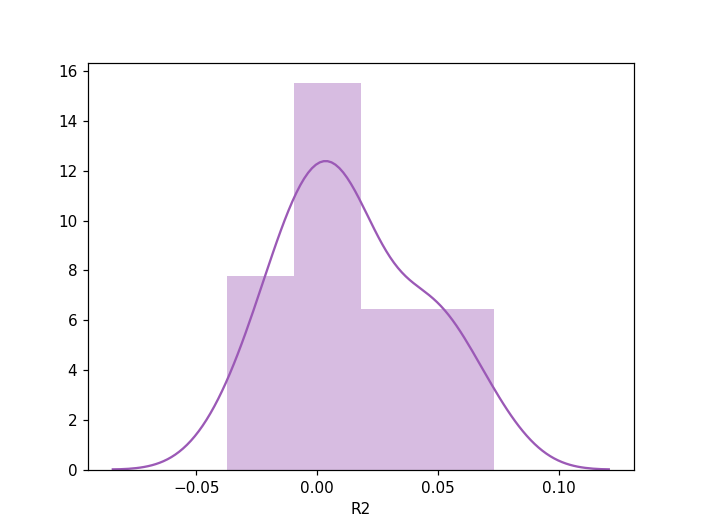

(-0.037105498623261512, 0.073302019926922313)


In [827]:
pl.figure()
sns.distplot(regcoefs['R2'])
print(regcoefs['R2'].min(), regcoefs['R2'].max())

#### classify and sort neurons

In [798]:
state_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state'

In [830]:
fit_thr = 0.05

good_fits = regcoefs[regcoefs['R2']>=fit_thr].copy()
print(good_fits.shape)

(4, 6)


<IPython.core.display.Javascript object>


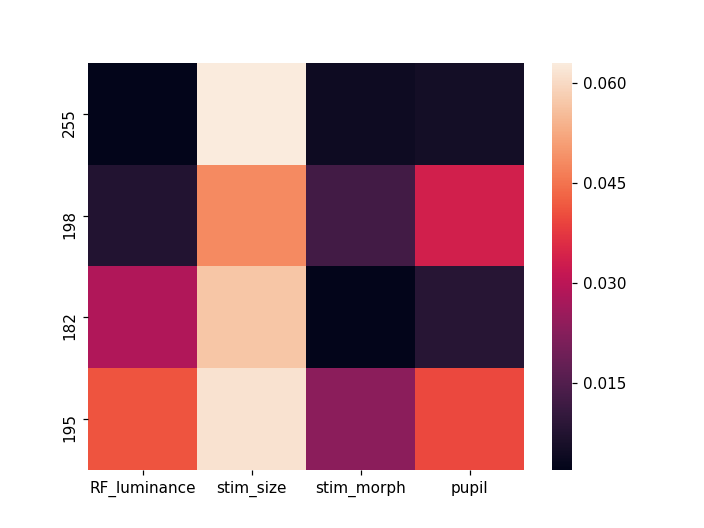

coefs_R2-0.05__regr-RF_luminance-stim_size-stim_morph-pupil


In [831]:
#regressor_names = ['RF_luminance', 'morph', 'size']

regressor_placeholders = ['x%i' % i for i in np.arange(0., len(regressor_names))]

fig, ax = pl.subplots() #pl.figure()
sns.heatmap(good_fits.abs().sort_values(by='x0')[regressor_placeholders], ax=ax)
ax.set_xticklabels(regressor_names)

regr_str = '-'.join(regressor_names)
figname = 'coefs_R2-%.2f__regr-%s' % (fit_thr, regr_str)
print(figname)

pl.savefig(os.path.join(neuraltypes_dir, '%s_%s.svg' % (figname, datakey)))

### Make pretty psth

In [832]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.cm as cm

def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace[0], trace, np.ones(windowsz)*trace[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2

def create_color_bar(fig, hue_colors, orientation='horizontal', cbar_axes=[0.58, 0.17, 0.3, 0.02]):

    cmap = ListedColormap(hue_colors)
    bounds = np.arange(0, len(hue_values))
    norm = BoundaryNorm(bounds, cmap.N)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array(bounds)

    cbar_ax = fig.add_axes(cbar_axes)
    cbar = fig.colorbar(mappable, cax=cbar_ax, boundaries=np.arange(-0.5,len(hue_values),1), \
                        ticks=bounds, norm=norm, orientation='horizontal')
    cbar.ax.tick_params(axis='both', which='both',length=0)
    cbar.ax.set_xticklabels(hue_values, fontsize=6) #(['%i' % i for i in morphlevels])  # horizontal colorbar
    cbar.ax.set_xlabel(hue_param, fontsize=10)

    return cbar


def pretty_psth(roi_traces, labels, sdf, colormap='coolarm', ymax=None):
    morphs = np.array(sorted(sdf['morphlevel'].unique()))
    sizes = np.array(sorted(sdf['size'].unique()))

    transform_param = 'size'
    transform_values = sorted(sdf[transform_param].unique())
    hue_param = 'morphlevel'
    hue_values = sorted(sdf[hue_param].unique())

    hue_colors = sns.color_palette(colormap, n_colors=len(hue_values))
    if hue_param == 'morphlevel':
        hue_colors[0] = (0, 0, 0)
        new_colors = sns.color_palette(colormap, n_colors=len(hue_values)-1)
        hue_colors[1:] = new_colors
        
    min_val, max_val = 0, 0
    windowsz=5


    n_transforms = len(sizes)
    fig, axes = pl.subplots(1, len(transform_values), figsize=(8,3), sharex=True)
    for hi, hue_value in enumerate(hue_values):
        currcfgs = sdf[sdf[hue_param]==hue_value].index.tolist()
        currlabels = labels[labels['config'].isin(currcfgs)]
        for cfg, g in currlabels.groupby(['config']):
            currsz = sdf[transform_param][cfg]
            plot_ix = transform_values.index(currsz)
            tsec =  np.nanmean(np.vstack(g.groupby(['trial'])['tsec'].apply(np.array).values), axis=0).astype(float)
            meantrace = np.nanmean(np.array([roi_traces[gg.index] for trial, gg in g.groupby(['trial'])]), axis=0)
            semtrace = spstats.sem(np.array([roi_traces[gg.index] for trial, gg in g.groupby(['trial'])]), axis=0, nan_policy='omit')

            st = temporal_downsample(tsec, windowsz)
            sm = temporal_downsample(meantrace, windowsz)
            ss = temporal_downsample(semtrace, windowsz)

            axes[plot_ix].plot(st, sm, color=hue_colors[hi], label=hue_value, lw=0.5)
            axes[plot_ix].fill_between(st, sm+ss, sm-ss, color=hue_colors[hi], alpha=0.2)
            max_val = max([max_val, (sm+ss).max() ])
            min_val = min( [min_val, (sm-ss).min()])

    if ymax is None:
        ymax = int(np.floor(max_val))
    for ai, (ax, sz) in enumerate(zip(axes.flat, transform_values)):
        ax.set_title(int(sz))
        ax.set_ylim([min_val, max_val])
        ax.tick_params(which='both', axis='both', length=0)
        if ai == 0:
            ax.set_xticks([0, 1])
            ax.set_xticklabels([''])
            ax.set_xlabel('1 s')
            ax.set_yticks([0, ymax])
            ax.set_yticklabels([''])
            ax.set_ylabel('%.1f dF/F' % ymax)
            sns.despine(trim=True, ax=ax, offset=4)
        else:
            sns.despine(trim=True, ax=ax, offset=4, left=True, bottom=False)
            ax.set_yticklabels([''])
            ax.set_yticks([]) 
    pl.subplots_adjust(top=0.7, bottom=0.3, left=0.1)
    cbar = create_color_bar(fig, hue_colors,  cbar_axes=[0.35, 0.15, 0.3, 0.02])
    cbar.ax.set_xticklabels(hue_values, fontsize=6) #(['%i' % i for i in morphlevels])  # horizontal colorbar
    return fig


In [833]:

visual_area = dsets[(dsets['animalid']==animalid) & (dsets['session']==session)]['visual_area'].unique()[0]
skey = '-'.join([animalid, session, fov, traceid])
print(skey)

roidir = os.path.join(neuraltypes_dir, 'example-cells', '%s_%s' % (visual_area, skey))
if not os.path.exists(roidir):
    os.makedirs(roidir)

# Load experiment neural data
fov = 'FOV%i_zoom2p0x' % fovnum
exp = util.Objects(animalid, session, fov, traceid=traceid)
exp.load(trace_type='dff', update_self=True, make_equal=True)
dff_traces = exp.data.traces 

sdf = reformat_morph_values(exp.data.sdf)
labels = exp.data.labels

JC099-20190609-FOV1_zoom2p0x-traces001
... [JC099|20190609|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2be711_traces001_333f6c_traces001_31bd42_traces001_0b8503_traces001_2d8e76_traces001_8fe19c/data_arrays/np_subtracted.npz
NP_subtracted offset was: -8.24
adding NP offset... (NP baseline offset: 440.84)
((168000, 311), (311,), ())
... updating self


In [834]:
print(roidir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/neural-types/example-cells/Li_JC099-20190609-FOV1_zoom2p0x-traces001


<IPython.core.display.Javascript object>


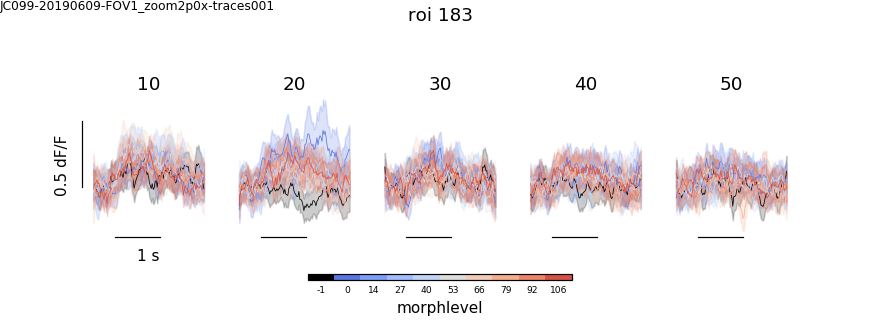

<IPython.core.display.Javascript object>


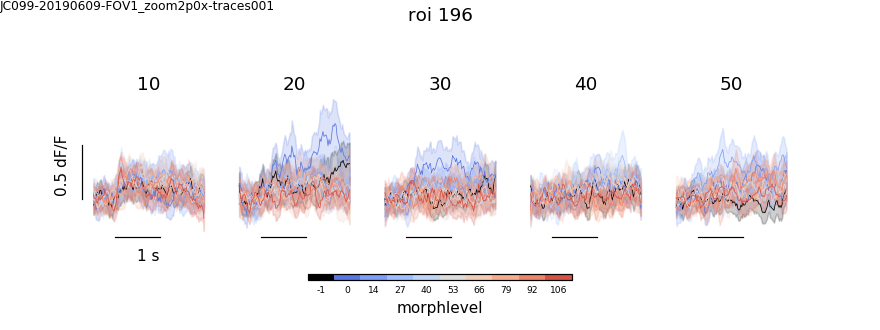

<IPython.core.display.Javascript object>


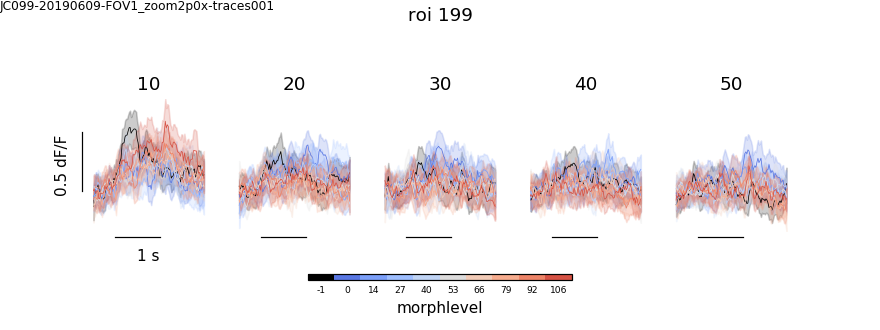

<IPython.core.display.Javascript object>


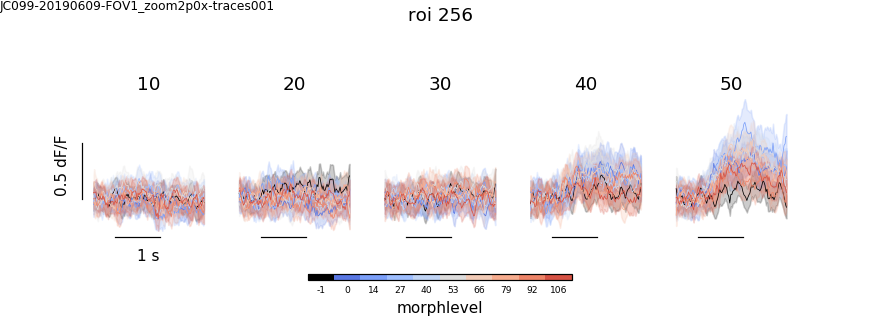

In [835]:

for rid in good_fits['rid'].unique():

    fig = pretty_psth(dff_traces[rid], labels, sdf, colormap='coolwarm', ymax=0.5)
    fig.suptitle('roi %i' % (int(rid+1)))
    label_figure(fig, skey)

    pl.savefig(os.path.join(roidir, 'roi%05d.svg' % int(rid+1)))


#### clf

In [836]:
good_fits.sort_values(by='rid')

,R2,rid,x0,x1,x2,x3
182,0.053675,182,0.028576,-0.056825,0.001940,0.008236
195,0.051751,195,0.041268,-0.061465,-0.023313,0.039846
198,0.073302,198,-0.007654,-0.048041,-0.012627,0.033540
255,0.067976,255,-0.002063,0.063005,-0.004319,-0.005120


In [837]:
regressor_mapping = dict((x, n) for x, n in zip(regressor_placeholders, regressor_names))
print(regressor_mapping)

{'x2': 'stim_morph', 'x3': 'pupil', 'x0': 'RF_luminance', 'x1': 'stim_size'}


In [838]:
roi_types = dict((r, []) for r in regressor_names)

for rid, g in good_fits.groupby(['rid']):
    max_weight = float(g[regressor_placeholders].abs().max().max())
    type_name = [r for r in regressor_placeholders if float(g[r].abs().values) == max_weight][0]
    
    roi_types[regressor_mapping[type_name]].append( (rid, max_weight) )
    

In [839]:
import pprint
pp = pprint.PrettyPrinter(indent=4, width=80)

In [840]:
rvals

[(147, 0.08249148370111122)]

In [841]:
ixs = np.argsort([r[1] for r in rvals])

In [842]:
for rname, rvals in roi_types.items():
    print(rname)
    ixs = np.argsort([r[1] for r in rvals])[::-1]
    for (rid, wt) in np.array(rvals)[ixs]:
        print(rid, wt)


stim_morph
stim_size
(255.0, 0.063004772188253844)
(195.0, 0.06146509210037443)
(182.0, 0.056824558801954)
(198.0, 0.048040958861371164)
pupil
RF_luminance


In [429]:
g[regressor_names].abs()

,RF_luminance,morph,size
233,0.018042,0.010008,0.078869


# Get n cells per visual area

In [55]:
counts = dict((k, []) for k in ['V1', 'Lm', 'Li'])
for k, o in MODELS.items():
    #print(k, len(o.keys()))
    sess, animal, fv, exp = k.split('_')
    varea = dsets[(dsets['animalid']==animal) & (dsets['session']==sess)]['visual_area'].iloc[0]
    
    counts[varea].append(len(o.keys()))

In [436]:
for k, v in counts.items():
    print k, np.sum(v)

V1 1079
Lm 1095
Li 938


In [437]:
R2_all.groupby(['visual_area']).mean()

,R2,pval,sig
visual_area,,,
Li,0.011168,0.189322,0.582090
Lm,0.006915,0.230240,0.482192
V1,0.015832,0.128729,0.678406


In [438]:
R2_all[R2_all['sig']==1].groupby(['visual_area']).mean()

,R2,pval,sig
visual_area,,,
Li,0.018526,0.006598,1
Lm,0.013481,0.006770,1
V1,0.022863,0.004224,1


In [439]:
R2_all.groupby(['visual_area']).count()

,R2,datakey,pval,sig
visual_area,,,,
Li,938,938,938,938
Lm,1095,1095,1095,1095
V1,1079,1079,1079,1079


# Fit model

In [50]:


def fit_linear_model_per_roi(residuals_pupil, residuals_neural, datakey, visual_area, indepvar_x='pupildiam'):

    responsive_cells = residuals_neural.columns.tolist()
    pupil_values = residuals_pupil.sort_values(by='trial')['pupil']
    #dropped_ = np.where(np.isnan(pupil_values))[0]
    #keep_ = np.array([i for i in np.arange(0, len(pupil_values)) if i not in dropped_])
    dropped_ = np.array([i for i in pupil_values.index.tolist() if np.isnan(i)])
    keep_ = np.array([i for i in pupil_values.index.tolist() if i not in dropped_])

    #xdf = residuals_neural.iloc[keep_].copy()
    xdf = residuals_neural.loc[keep_].copy()
    xdf['pupildiam'] = pupil_values[keep_].copy()

    ols = {}
    for rid in responsive_cells:
        roi_index = list(responsive_cells).index(rid)

        model = sm.OLS(xdf[rid], sm.add_constant(xdf[indepvar_x]))
        modelfit = model.fit()
        p = modelfit.params

        ols[rid] = modelfit


    R2 = pd.DataFrame({'R2': [ols[rid].rsquared for rid in responsive_cells],
                       'pval': [ols[rid].f_pvalue for rid in responsive_cells],
                       'datakey': [datakey for _ in np.arange(0, len(responsive_cells))],
                       'visual_area': [visual_area for _ in np.arange(0, len(responsive_cells))]})
    return ols, R2



In [60]:
dsets.head()

,index,animalid,experiment,fov,session,visual_area,fovnum
0,2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,1
1,6,JC084,blobs,FOV1_zoom2p0x,20190525,Lm,1
2,12,JC091,blobs,FOV1_zoom2p0x,20190627,Lm,1
4,22,JC091,blobs,FOV1_zoom2p0x,20190607,Li,1
5,26,JC091,blobs,FOV1_zoom2p0x,20190614,Li,1


# OLS for each neuron

In [518]:
bad_diams = []
f_MODELS = {}
f_R2list = []

fit_residuals = True
data_type = 'residuals_' if fit_residuals else ''

for datakey in DATA.keys():
    neuraldf = DATA[datakey]['%sneural' % data_type]
    pupildf = DATA[datakey]['%spupil' % data_type]
    #assert len(np.where(pupildf < 0)[0]) == 0, "Bad"
    if len(np.where(pupildf < 0)[0]) != 0 and fit_residuals is False:
        print("%s -- Bad pupil measures" % datakey)
        bad_diams.append(datakey)
        continue
    session, animalid, fovn, cexp = datakey.split('_')
    fovnum = int(fovn[3:])
    visual_area = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==fovnum)]['visual_area'].iloc[0]
    
    # Fit model to     
    ols, R2 = fit_linear_model_per_roi(pupildf, neuraldf,
                               visual_area=visual_area, datakey=datakey,
                               indepvar_x='pupildiam')
    f_MODELS[datakey] = ols
    f_R2list.append(R2)
R2_f = pd.concat(f_R2list, axis=0)


In [519]:
metric = 'R2' 
R2_by_session = []
for visual_area, g in R2_f.groupby(['visual_area']):
    if metric == 'pval':
        vals = g[g['sig']==1].groupby(['datakey']).mean()[metric]
    else:
        vals = g.groupby(['datakey']).mean()[metric]
    
    R2_by_session.append(pd.DataFrame({'R2': vals,
                                      'visual_area': visual_area}))
R2_by_session = pd.concat(R2_by_session, axis=0)


<IPython.core.display.Javascript object>


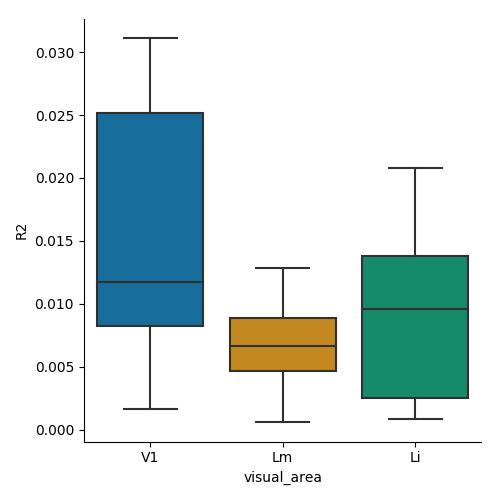

ols_by-session_fit-residuals_R2


In [521]:
#pl.figure()

sns.catplot(x='visual_area', y='R2', kind='box', data=R2_by_session, order=['V1', 'Lm', 'Li'],
           palette='colorblind')

fit_str = 'residuals' if fit_residuals else 'responses'
figname = 'ols_by-session_fit-%s_%s'  % (fit_str, metric)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)


## Stats?

In [522]:
import statsmodels.stats.multicomp as ml


In [523]:
c1 = R2_by_session[R2_by_session['visual_area']=='V1']['R2']
c2 = R2_by_session[R2_by_session['visual_area']=='Lm']['R2']
c3 = R2_by_session[R2_by_session['visual_area']=='Li']['R2']
print(c1.shape, c2.shape, c3.shape)

((10,), (11,), (11,))


In [524]:
# Shapiro-Wilk normality test 
spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) 

# Shapiro-Wilk normality test 
spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) 

((0.8674817085266113, 0.09342168271541595),
 (0.9127958416938782, 0.2631151080131531),
 (0.9018121957778931, 0.19449283182621002))

In [525]:
F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
#print(scores.shape)
#print(groups.shape)


# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

F statistic = 3.314 and probability p = 0.051
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm   -0.0022  -0.0103 0.0059 False 
  Li     V1    0.0062  -0.0021 0.0144 False 
  Lm     V1    0.0084   0.0001 0.0166  True 
--------------------------------------------


#### Collapse all neurons

In [526]:
R2_f.groupby(['visual_area']).mean()

,R2,pval
visual_area,,
Li,0.011168,0.189322
Lm,0.006915,0.230240
V1,0.015832,0.128729


In [527]:
R2_f['sig'] = [1 if p<0.05 else 0 for p in R2_f['pval']]
R2_f[R2_f['sig']==1].groupby(['visual_area']).mean()

,R2,pval,sig
visual_area,,,
Li,0.018526,0.006598,1
Lm,0.013481,0.006770,1
V1,0.022863,0.004224,1


<IPython.core.display.Javascript object>


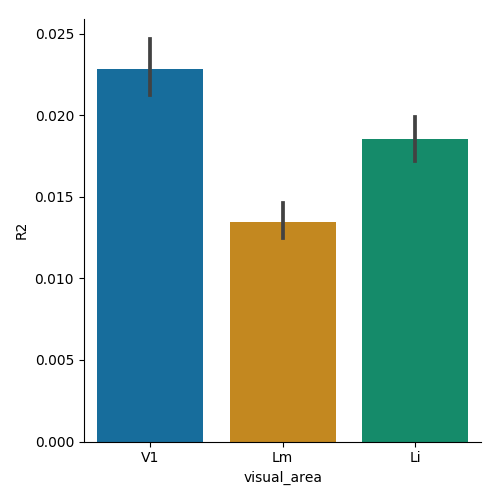

residuals


In [528]:
#fig, ax = pl.subplots(1,2, figsize=(10,4))
sns.catplot(x='visual_area', y='R2', kind='bar',
            data=R2_f[R2_f['sig']==1], palette='colorblind', order=['V1', 'Lm', 'Li'],
            #hue='sig',
            alpha=1, height=5, legend_out=False) #ax[0]) #, ax=ax) #, ax=ax) #color='k', alpha=0.1, ax=ax)

pl.ylabel('R2')

#pl.show()

pl.savefig(os.path.join(outdir, 'ols_collapse-sessions_fit-%s.png' % fit_str))
print(fit_str)

# Ridge

In [539]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer, quantile_transform
#from sklearn.compose import TransformedTargetRegressor
import sklearn.metrics as skmetrics #import median_absolute_error, r2_score



In [531]:
import sklearn
sklearn.__version__

'0.19.1'

In [532]:
datakey

'20190616_JC097_fov1_blobs'

In [305]:
neuraldf = DATA[datakey]['neural']
pupildf = DATA[datakey]['pupil']
session, animalid, fovn, cexp = datakey.split('_')
fovnum = int(fovn[3:])
visual_area = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==fovnum)]['visual_area'].iloc[0]

# Split test set
curr_rois = [col for col in neuraldf.columns.tolist() if col != 'config']
train_x = neuraldf[curr_rois].iloc[0::2]
test_x = neuraldf[curr_rois].iloc[1::2]
train_y = pupildf['pupil'].iloc[0::2]
test_y = pupildf['pupil'].iloc[1::2]

scaler = StandardScaler().fit(train_x.values)


In [307]:
ridge = Ridge(normalize=False)

# Grid search
params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
n_folds = None
grid = GridSearchCV(ridge, params, scoring='mean_squared_error') #, 
                          #cv=None, store_cv_values=True)
grid.fit(scaler.transform(train_x), train_y)

# summarize results
#grid_results.append(pd.DataFraem('datakey': datake grid.best_score_)
print(grid.best_estimator_.alpha)

10.0


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error 

In [533]:
# f_MODELS = {}
# f_R2list = []
grid_results = []
for di, datakey in enumerate(DATA.keys()):
    neuraldf = DATA[datakey]['neural']
    pupildf = DATA[datakey]['pupil']
    session, animalid, fovn, cexp = datakey.split('_')
    fovnum = int(fovn[3:])
    visual_area = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==fovnum)]['visual_area'].iloc[0]
    
    # Split test set
    curr_rois = [col for col in neuraldf.columns.tolist() if col != 'config']
    train_x = neuraldf[curr_rois].iloc[0::2]
    test_x = neuraldf[curr_rois].iloc[1::2]
    train_y = pupildf['pupil'].iloc[0::2]
    test_y = pupildf['pupil'].iloc[1::2]
    scaler = StandardScaler().fit(train_x.values)
    
    # Grid search
    params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
    n_folds = None
    ridge = Ridge(normalize=False)
    grid = GridSearchCV(ridge, params, scoring='neg_mean_squared_error') #, 
                              #cv=None, store_cv_values=True)
    grid.fit(scaler.transform(train_x), train_y)
    
    grid_results.append(pd.DataFrame({'visual_area': visual_area,
                         'datakey': datakey,
                         'best_alpha': grid.best_estimator_.alpha,
                          'best_mse': grid.best_score_}, index=[di]) )
    
grid_results = pd.concat(grid_results, axis=0)

#     f_MODELS[datakey] = {'data': {'train_x': train_x, 
#                                   'train_y': train_y,
#                                   'test_x': test_x,
#                                   'test_y': test_y},
#                          'grid_results': grid}
                          
    
#     ols, R2 = fit_linear_model_per_roi(pupildf, neuraldf,
                                       
#                                visual_area=visual_area, datakey=datakey,
#                                indepvar_x='pupildiam')
#     f_MODELS[datakey] = ols
#     f_R2list.append(R2)
# R2_f = pd.concat(f_R2list, axis=0)
# R2_f['sig'] = [1 if p<0.01 else 0 for p in R2_f['pval']]


In [534]:
grid_results.groupby(['visual_area']).mean()

,best_alpha,best_mse
visual_area,,
Li,10.0,-37.051330
Lm,10.0,-18.919736
V1,10.0,-19.401806


In [535]:
datakey

'20190616_JC097_fov1_blobs'

In [536]:
neuraldf = DATA[datakey]['neural']
pupildf = DATA[datakey]['pupil']
session, animalid, fovn, cexp = datakey.split('_')
fovnum = int(fovn[3:])
visual_area = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==fovnum)]['visual_area'].iloc[0]

# Split test set
curr_rois = [col for col in neuraldf.columns.tolist() if col != 'config']
train_x = neuraldf[curr_rois].iloc[0::2]
test_x = neuraldf[curr_rois].iloc[1::2]
train_y = pupildf['pupil'].iloc[0::2]
test_y = pupildf['pupil'].iloc[1::2]
scaler = StandardScaler().fit(train_x.values)

# Grid search
#params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
#n_folds = None
ridge = RidgeCV(normalize=False, cv=None, store_cv_values=True)
# ridge = TransformedTargetRegressor(
#     regressor=RidgeCV(),
#     transformer=QuantileTransformer(n_quantiles=300,
#                                     output_distribution='normal'))
#regr_trans.fit(X_train, y_train)

ridge.fit(scaler.transform(train_x), train_y)
prediction = ridge.predict(scaler.transform(test_x))
R2_score = ridge.score(scaler.transform(test_x), test_y)
print(R2_score)

0.194060702115


In [434]:
prediction.shape

(749,)

<IPython.core.display.Javascript object>


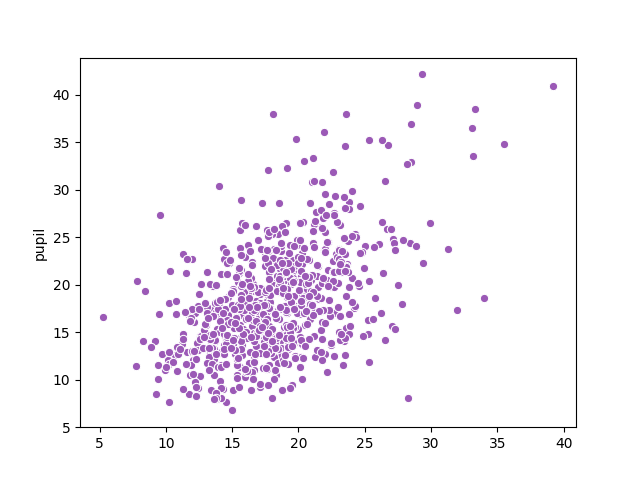

In [435]:
pl.figure()
sns.scatterplot(prediction, test_y)

In [191]:
train_x.shape

(750, 188)

In [550]:
fit_residuals = True

data_type = 'residuals_' if fit_residuals else ''
ridge_results = []
for di, datakey in enumerate(DATA.keys()):
    neuraldf = DATA[datakey]['%sneural' % data_type]
    pupildf = DATA[datakey]['%spupil' % data_type]
    session, animalid, fovn, cexp = datakey.split('_')
    fovnum = int(fovn[3:])
    visual_area = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==fovnum)]['visual_area'].iloc[0]
    
    # Split test set
    curr_rois = [col for col in neuraldf.columns.tolist() if col != 'config']
    train_x = neuraldf[curr_rois].iloc[0::2]
    test_x = neuraldf[curr_rois].iloc[1::2]
    train_y = pupildf['pupil'].iloc[0::2]
    test_y = pupildf['pupil'].iloc[1::2]
    scaler = StandardScaler().fit(train_x.values)

    # Grid search
    regr_ridge = RidgeCV(normalize=False, cv=None, store_cv_values=False, gcv_mode='svd')
    regr_ridge.fit(scaler.transform(train_x), train_y)
    prediction = regr_ridge.predict(scaler.transform(test_x))
    R2_score = regr_ridge.score(scaler.transform(test_x), test_y)
    MAE =  skmetrics.median_absolute_error(test_y, prediction)
    #print(R2_score)
    r, pval = spstats.pearsonr(test_y, prediction)
    
    ridge_results.append(pd.DataFrame({'visual_area': visual_area,
                                      'datakey': datakey,
                                       'MAE': MAE,
                                      'R2': R2_score, 
                                       'pearson_r': r,
                                       'p_value': pval}, index=[di]) )
                        
    
ridge_results = pd.concat(ridge_results, axis=0)

<IPython.core.display.Javascript object>


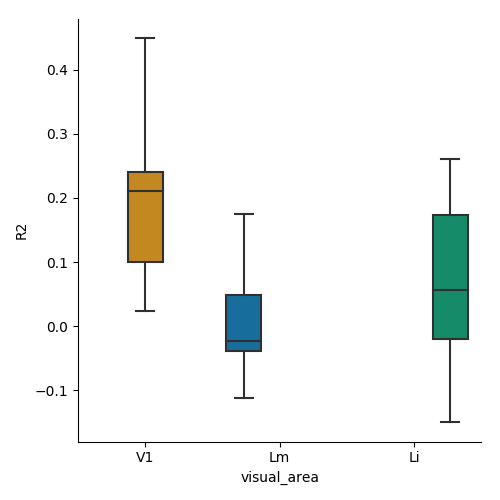

ridge_fit-residuals_R2


In [551]:
#fig, ax = pl.subplots()

#R2_f['sig'] = [1 if p<0.01 else 0 for p in R2_f['pval']]
#R2['empty'] = [1 for _ in np.arange(0, R2.shape[0])]
metric = 'R2'

sns.catplot(x='visual_area', y=metric, kind='box', palette='colorblind', order=['V1', 'Lm', 'Li'],
            hue='visual_area', data=ridge_results[ridge_results['p_value']<0.05]) #, 
            #alpha=0.5, height=5, legend_out=False, ax=ax) #, ax=ax) #color='k', alpha=0.1, ax=ax)

pl.ylabel(metric)
#pl.xticks([])
#pl.xlabel('')

#pl.subplots_adjust(right=0.9)
label_figure(fig, datakey)

fit_str = 'residuals' if fit_residuals else 'responses'
figname = 'ridge_fit-%s_%s'  % (fit_str, metric)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)

#### Stats

In [552]:
c1 = ridge_results[(ridge_results['p_value']<0.05) & (ridge_results['visual_area']=='V1')]['R2']
c2 = ridge_results[(ridge_results['p_value']<0.05) & (ridge_results['visual_area']=='Lm')]['R2']
c3 = ridge_results[(ridge_results['p_value']<0.05) & (ridge_results['visual_area']=='Li')]['R2']
print(c1.shape, c2.shape, c3.shape)

((9,), (9,), (10,))


In [553]:
F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
#print(scores.shape)
#print(groups.shape)


# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

F statistic = 5.148 and probability p = 0.013
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm    -0.047  -0.1881 0.0942 False 
  Li     V1    0.1325  -0.0086 0.2736 False 
  Lm     V1    0.1795   0.0346 0.3243  True 
--------------------------------------------


<IPython.core.display.Javascript object>


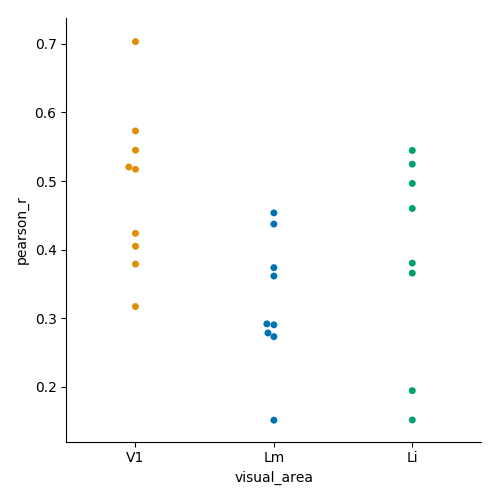

Text(9.44444,0.5,u'pearson_r')

In [554]:
metric = 'pearson_r'

sns.catplot(x='visual_area', y=metric, kind='swarm', palette='colorblind', order=['V1', 'Lm', 'Li'],
            hue='visual_area', data=ridge_results[ridge_results['p_value']<0.01]) #, 
            #alpha=0.5, height=5, legend_out=False, ax=ax) #, ax=ax) #color='k', alpha=0.1, ax=ax)

pl.ylabel(metric)
#pl.xticks([])
#pl.xlabel('')


In [431]:
ridge_results.shape

(32, 5)

# Fano Factor

In [241]:
datakey

'20190616_JC097_fov1_blobs'

In [423]:
fano_dfs = []
neuraldf = DATA[datakey]['neural']
pupildf = DATA[datakey]['pupil']
print(neuraldf.shape)
curr_rois = neuraldf.columns.tolist()
for rid in curr_rois:
    fano_factor = np.array([np.var(abs(neuraldf[rid].loc[g.index]), ddof=1) / np.nanmean(abs(neuraldf[rid].loc[g.index])) \
                     for cfg, g in pupildf.groupby(['config'])])

    response_mag = np.array([np.nanmean(abs(neuraldf[rid].loc[g.index])) for cfg, g in pupildf.groupby(['config'])])
    #print(response_mag.shape, fano_factor.shape)
    
    fdf = pd.DataFrame({'fano_factor': fano_factor,
                        'response_mag': response_mag,
                        'rid': [rid for _ in np.arange(0, len(fano_factor))]})
    fano_dfs.append(fdf)

(1499, 188)


In [424]:
fano_df = pd.concat(fano_dfs, axis=0)

In [558]:
nrois = len(fano_df['rid'].unique())
colorlist = sns.color_palette('cubehelix', n_colors = nrois)
roi_colors = dict((r, col) for r, col in zip(fano_df['rid'].unique(), colorlist))

In [562]:
sorted_ixs = np.argsort(g['response_mag'])



<IPython.core.display.Javascript object>


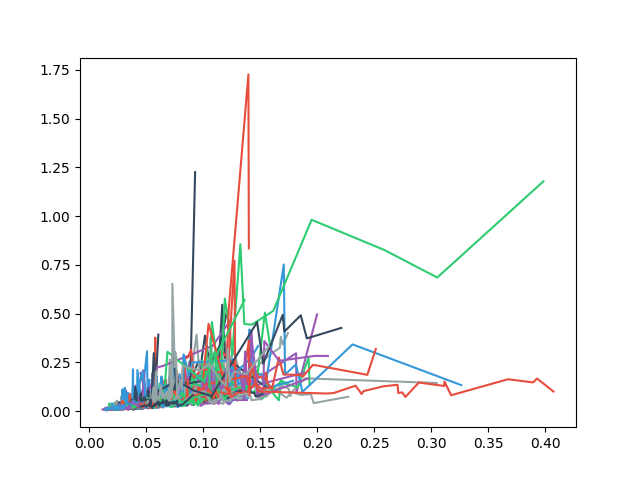

In [567]:
pl.figure()
for rid, g in fano_df.groupby(['rid']):
    sorted_ixs = np.argsort(g['response_mag'])
    pl.plot(g['response_mag'][sorted_ixs], g['fano_factor'][sorted_ixs]) #, color=roi_colors[rid])
#sns.scatterplot(x='response_mag', y='fano_factor', hue='rid', palette='hsv', data=fano_df)

In [421]:
g.shape

(50, 3)

In [367]:
neuraldf.shape

(1499, 188)

In [342]:
fanos = []
for cfg, g in pupildf.groupby(['config']):
    ff_pupil = [float( np.var(g['pupil'], ddof=1) / np.nanmean(g[['pupil']]) ) \
                for cfg, g in pupildf.groupby(['config'])]
    
    ff_neural = [np.var(abs(neuraldf[rid].loc[g.index]), ddof=1) / np.nanmean(abs(neuraldf[rid].loc[g.index]))\
                 for cfg, g in pupildf.groupby(['config'])]
    
    nrois = len(ff_neural)
    fanos.append( pd.DataFrame({'config': [cfg for _ in np.arange(nrois)],
                  'ff_pupil': [ff_pupil for _ in np.arange(nrois)],
                  'ff_neural': ff_neural,
                  'roi': neuraldf.columns.tolist()}) )
    
fanos = pd.concat(fanos, axis=0)

In [374]:
fit_residuals = True

data_type = 'residuals_' if fit_residuals else ''
#for di, datakey in enumerate(DATA.keys()):
neuraldf = DATA[datakey]['%sneural' % data_type]
pupildf = DATA[datakey]['%spupil' % data_type]
session, animalid, fovn, cexp = datakey.split('_')
fovnum = int(fovn[3:])
visual_area = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==fovnum)]['visual_area'].iloc[0]


<IPython.core.display.Javascript object>


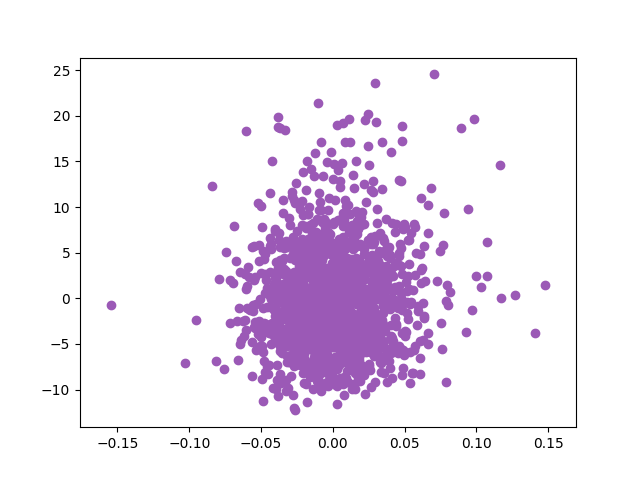

In [379]:
pl.figure()
pl.scatter(neuraldf[rid], pupildf['pupil'])


In [389]:
print(rid)
ff_pupil = float( np.var(abs(pupildf['pupil']), ddof=1) / np.nanmean(abs(pupildf['pupil'])) )

ff_neural = float( np.var(abs(neuraldf[rid]), ddof=1) / np.nanmean(abs(neuraldf[rid])) )

print(rid, ff_pupil, ff_neural)

431
(431, 2.853716963408797, 0.016341970374077086)


In [390]:
curr_rois = neuraldf.columns.tolist()
ff_neurals = [float( np.var(abs(neuraldf[rid]), ddof=1) / np.nanmean(abs(neuraldf[rid])) ) \
 for rid in curr_rois]


<IPython.core.display.Javascript object>


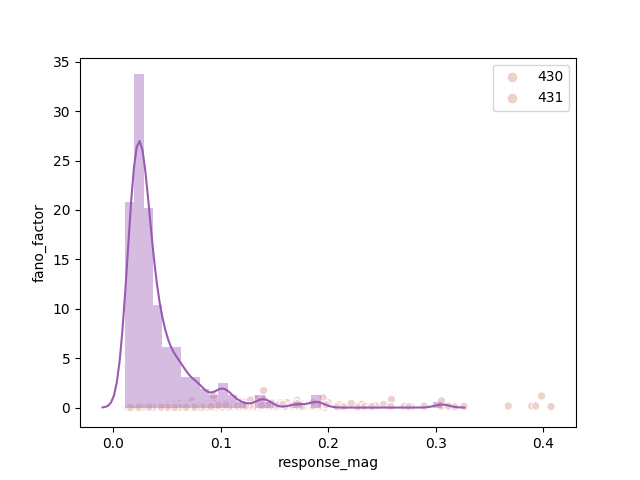

In [392]:
pl.figure()
sns.distplot(ff_neurals)

In [373]:
len(ff_pupil), len(ff_neural)

(50, 50)

In [353]:
ff_neural

ff_neural  ff_pupil
roi config                        
90  config001   0.021902  1.651433
    config002   0.020529  1.284894
    config003   0.019403  1.800445
    config004   0.018906  2.473949
    config005   0.016051  0.968366
    config006   0.031666  1.246181
    config007   0.060472  1.829322
    config008   0.039056  1.549972
    config009   0.058407  2.145511
    config010   0.021684  1.387653
    config011   0.064109  1.622180
    config012   0.071483  1.183094
    config013   0.047775  1.329624
    config014   0.049043  1.364685
    config015   0.043814  1.692130
    config016   0.047894  1.307047
    config017   0.083515  1.820424
    config018   0.092135  1.629192
    config019   0.043616  1.069145
    config020   0.031477  2.188173
    config021   0.065968  1.447792
    config022   0.071349  2.078376
    config023   0.075133  1.539280
    config024   0.090707  4.287219
    config025   0.028993  1.470476
    config026   0.063267  1.570605
    config027   0.077263  1.255422
    config028   0.093379  2.061260
    config029   0.096978  1.316704
    config030   0.030043  1.603102
    config031   0.040861  1.840564
    config032   0.053224  0.983299
    config033   0.057630  2.965408
    config034   0.060198  2.820902
    config035   0.049017  1.900978
    config036   0.046137  1.550385
    config037   0.037928  1.662427
    config038   0.075614  1.649709
    config039   0.077097  0.819739
    config040   0.044265  1.964044
    config041   0.052288  2.448013
    config042   0.057330  2.141988
    config043   0.059148  1.629000
    config044   0.058845  1.756102
    config045   0.087468  1.014411
    config046   0.099958  2.390653
    config047   0.056967  2.123924
    config048   0.038620  2.213379
    config049   0.125657  0.807814
    config050   0.073348  1.289718

In [345]:
np.var(abs(neuraldf[90].loc[g.index])) / abs(neuraldf[90].loc[g.index]).mean()

0.070903083787223153

<IPython.core.display.Javascript object>


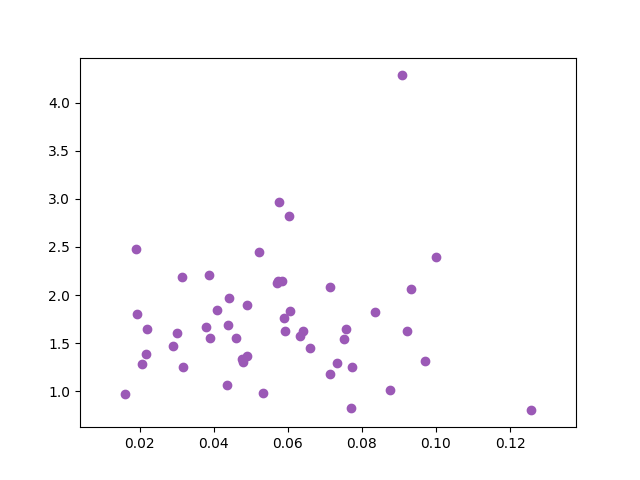

(0.047842244664200118, 0.74145414169491475)


In [355]:
pl.figure()
pl.scatter(avgs['ff_neural'].values, avgs['ff_pupil'].values)

pearson_r, p_value = spstats.pearsonr(avgs['ff_neural'].values, avgs['ff_pupil'].values)
print(pearson_r, p_value)

In [ ]:
fit_residuals = True

data_type = 'residuals_' if fit_residuals else ''
ridge_results = []
for di, datakey in enumerate(DATA.keys()):
    neuraldf = DATA[datakey]['%sneural' % data_type]
    pupildf = DATA[datakey]['%spupil' % data_type]
    session, animalid, fovn, cexp = datakey.split('_')
    fovnum = int(fovn[3:])
    visual_area = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==fovnum)]['visual_area'].iloc[0]
    
    # Split test set
    curr_rois = [col for col in neuraldf.columns.tolist() if col != 'config']
    train_x = neuraldf[curr_rois].iloc[0::2]
    test_x = neuraldf[curr_rois].iloc[1::2]
    train_y = pupildf['pupil'].iloc[0::2]
    test_y = pupildf['pupil'].iloc[1::2]
    scaler = StandardScaler().fit(train_x.values)

    # Grid search
    regr_ridge = RidgeCV(normalize=False, cv=5, store_cv_values=False, gcv_mode='svd')
    regr_ridge.fit(scaler.transform(train_x), train_y)
    prediction = regr_ridge.predict(scaler.transform(test_x))
    R2_score = regr_ridge.score(scaler.transform(test_x), test_y)
    #print(R2_score)
    r, pval = spstats.pearsonr(test_y, prediction)
    
    ridge_results.append(pd.DataFrame({'visual_area': visual_area,
                                      'datakey': datakey,
                                      'R2': R2_score, 
                                       'pearson_r': r,
                                       'p_value': pval}, index=[di]) )
                        
    
ridge_results = pd.concat(ridge_results, axis=0)

In [222]:
DATA[datakey].keys()

['residuals_pupil', 'pupil', 'residuals_neural', 'neural']

<IPython.core.display.Javascript object>


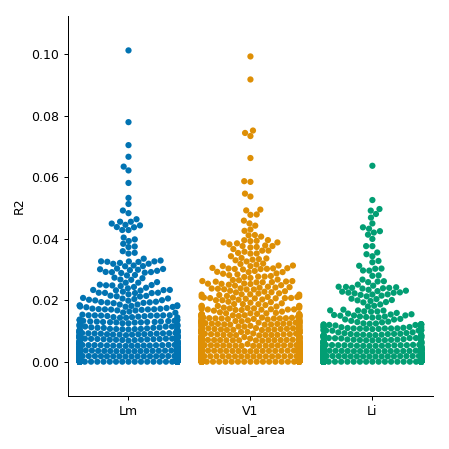

In [704]:
#fig, ax = pl.subplots()

R2_f['sig'] = [1 if p<0.05 else 0 for p in R2_f['pval']]
#R2['empty'] = [1 for _ in np.arange(0, R2.shape[0])]

sns.catplot(x='visual_area', y='R2', kind='swarm', palette='colorblind', #hue='sig', 
            data=R2_f) #, ax=ax) #color='k', alpha=0.1, ax=ax)
pl.ylabel('R2')
#pl.xticks([])
#pl.xlabel('')

label_figure(fig, datakey)

# Filter

# Get eyetracker acquisition info

# Get pupil residuals

In [649]:
residuals_pupil = pupilstats.copy()
for c, g in pupilstats.groupby(['config']):
    residuals_pupil['pupil'][g.index] = pupilstats.loc[g.index]['pupil'] - pupilstats.loc[g.index]['pupil'].mean()

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [555]:
plot_residuals = False

if plot_residuals:
    fig, ax = pl.subplots() #pl.figure()
    for c, g in residuals_pupil.groupby(['config']):
        ax.plot(g['pupil'].dropna(), alpha=0.5)


In [554]:
# for config, g in trial_key.groupby(['config']):
#    print(g.shape)

# Get neural responses and residuals

In [561]:
R2_all[R2_all['datakey']==datakey].shape

(141, 5)

In [608]:
residuals_neural = DATA[datakey]['residuals_neural']
residuals_pupil = DATA[datakey]['residuals_pupil']
responsive_cells = residuals_neural.columns.tolist()
print(len(responsive_cells))

141


In [609]:
pupil_values = residuals_pupil.sort_values(by='trial')['pupil']

In [610]:
residuals_pupil.head()

,config,pupil,trial
0,config025,2.946112,1.0
1,config024,-0.233637,2.0
2,config046,-1.472992,3.0
3,config013,0.046228,4.0
4,config002,-2.872295,5.0


In [611]:
residuals_neural.shape

(1582, 141)

In [641]:
#dropped_ = np.where(np.isnan(pupil_values))[0]
#keep_ = np.array([i for i in np.arange(0, len(pupil_values)) if i not in dropped_])

dropped_ = [i for i in pupil_values.index.tolist() if np.isnan(i)]
keep_ = np.array([i for i in pupil_values.index.tolist() if i not in dropped_])

print("N Nans:", len(dropped_))
print("N keep:", len(keep_))


('N Nans:', 0)
('N keep:', 1582)


In [642]:
dropped_ixs = np.where(np.isnan(pupil_values))[0]
dropped_trs = np.array([i for i in pupil_values.index.tolist() if np.isnan(i)])

keep_ixs = np.array([i for i in np.arange(0, len(pupil_values)) if i not in dropped_])
keep_trs = np.array([i for i in pupil_values.index.tolist() if i not in dropped_trs])


In [644]:
#xdf = residuals_neural.iloc[keep_].copy()
xdf = residuals_neural.loc[keep_].copy()
xdf['pupildiam'] = pupil_values[keep_].copy()


In [651]:
residuals_neural.shape

(1582, 141)

In [650]:
max(keep_)

1581

In [645]:
xdf.head()

,0,1,4,6,7,13,22,24,25,27,...,254,258,259,260,261,264,265,269,270,pupildiam
0,0.536666,-0.242237,0.276863,0.552535,-0.051407,-0.180313,0.003977,-0.036779,0.138382,0.464793,...,0.400809,0.327629,0.320027,0.479045,0.832553,-0.082252,0.327724,0.164935,-0.010489,2.946112
1,0.359389,0.034676,-0.091373,0.006093,-0.074069,-0.110579,-0.027672,-0.039527,-0.088495,0.060424,...,0.006097,0.355125,-0.053250,-0.151231,-0.093623,0.219817,-0.002453,0.077677,-0.022610,-0.233637
2,-0.356232,0.131639,-0.154972,-0.075936,-0.060184,0.038357,0.067955,-0.084018,-0.003566,0.101943,...,-0.131290,0.047555,-0.027075,0.033762,-0.081263,-0.079244,-0.027671,0.312830,0.123184,-1.472992
3,1.019509,-0.061945,0.136980,0.186179,0.018295,-0.042643,-0.115071,0.257502,0.154710,0.168349,...,0.008972,0.106587,0.125058,-0.012447,0.229084,-0.010587,0.068795,0.032344,-0.049751,0.046228
4,-0.061467,0.015477,-0.027016,-0.111911,-0.088562,0.122120,0.099153,-0.011372,0.211735,0.002475,...,-0.025114,-0.040375,0.070321,0.098636,-0.037986,0.127006,0.149954,-0.235430,0.014719,-2.872295


In [646]:
ols = {}
for rid in responsive_cells:
    roi_index = list(responsive_cells).index(rid)

    model = sm.OLS(xdf[rid], sm.add_constant(xdf['pupildiam']))
    modelfit = model.fit()
    #p = modelfit.params
    #modelfit.rquared

    ols[rid] = modelfit


In [647]:

R2 = pd.DataFrame({'R2': [ols[rid].rsquared for rid in responsive_cells],
                   'pval': [ols[rid].f_pvalue for rid in responsive_cells],
                   'datakey': [datakey for _ in np.arange(0, len(responsive_cells))],
                   'visual_area': [visual_area for _ in np.arange(0, len(responsive_cells))]})

In [648]:
model = sm.OLS(xdf[rid], sm.add_constant(xdf['pupildiam']))
modelfit = model.fit()
modelfit.params

const       NaN
pupildiam   NaN
dtype: float64

In [640]:
R2

,R2,datakey,pval,visual_area
0,6.926331e-05,20190605_JC090_fov1_blobs,0.740822,V1
1,2.914088e-03,20190605_JC090_fov1_blobs,0.031795,V1
2,9.989896e-04,20190605_JC090_fov1_blobs,0.208949,V1
3,4.066685e-05,20190605_JC090_fov1_blobs,0.799924,V1
4,6.107157e-03,20190605_JC090_fov1_blobs,0.001867,V1
5,9.266029e-04,20190605_JC090_fov1_blobs,0.226255,V1
6,1.496540e-05,20190605_JC090_fov1_blobs,0.877810,V1
7,2.802830e-04,20190605_JC090_fov1_blobs,0.505789,V1
8,1.006246e-03,20190605_JC090_fov1_blobs,0.207302,V1
9,1.675616e-04,20190605_JC090_fov1_blobs,0.606919,V1


In [551]:
# Get nrois x ntrials array
roi_responses = pd.DataFrame(np.vstack([exp.data.traces.iloc[g.index].mean(axis=0)\
                                    for trial, g in labels.groupby(['trial'])]))

# Get responsive cells
responsive_cells, ncells_total = exp.get_responsive_cells(response_type='dff',\
                                                          responsive_test='ROC', responsive_thr=0.05)
print("%i out of %i cells pass responsive test." % (len(responsive_cells), ncells_total))
neuraldata = roi_responses[responsive_cells]


In [559]:
trial_configs = pd.DataFrame(np.vstack([g['config'].iloc[0]\
                                    for trial, g in labels.groupby(['trial'])]), columns=['config'])

,config
0,config032
1,config031
2,config021
3,config020
4,config003
5,config043
6,config034
7,config005
8,config012
9,config009


In [604]:
residuals_neural = neuraldata.copy()

for c, g in trial_configs.groupby(['config']):
    residuals_neural.loc[g.index] = neuraldata.loc[g.index] - neuraldata.loc[g.index].mean(axis=0)

In [606]:
ols, R2 = fit_linear_model(residuals_pupil, residuals_neural)


In [607]:
datakey, R2

('20190605_JC090_fov1_blobs',
                R2                    datakey      pval visual_area
 0    6.926331e-05  20190605_JC090_fov1_blobs  0.740822          V1
 1    2.914088e-03  20190605_JC090_fov1_blobs  0.031795          V1
 2    9.989896e-04  20190605_JC090_fov1_blobs  0.208949          V1
 3    4.066685e-05  20190605_JC090_fov1_blobs  0.799924          V1
 4    6.107157e-03  20190605_JC090_fov1_blobs  0.001867          V1
 5    9.266029e-04  20190605_JC090_fov1_blobs  0.226255          V1
 6    1.496540e-05  20190605_JC090_fov1_blobs  0.877810          V1
 7    2.802830e-04  20190605_JC090_fov1_blobs  0.505789          V1
 8    1.006246e-03  20190605_JC090_fov1_blobs  0.207302          V1
 9    1.675616e-04  20190605_JC090_fov1_blobs  0.606919          V1
 10   1.007033e-06  20190605_JC090_fov1_blobs  0.968187          V1
 11   3.092700e-05  20190605_JC090_fov1_blobs  0.825077          V1
 12   1.784242e-04  20190605_JC090_fov1_blobs  0.595494          V1
 13   1.642839e-04

# Regression on residuals

In [48]:
import statsmodels.api as sm
from pipeline.python.utils import label_figure

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [598]:
%matplotlib notebook

In [659]:
residuals_neural.shape

(1500, 100)

In [660]:
residuals_pupil.shape

(1500, 3)

In [661]:
residuals_pupil.head()

,config,pupil,trial
0,config032,9.269252,1
1,config031,4.447400,2
2,config021,9.180851,3
3,config020,6.928909,4
4,config003,1.817075,5


In [664]:
pupil_values = residuals_pupil.sort_values(by='trial')['pupil']
dropped_ = np.where(np.isnan(pupil_values))[0]
keep_ = np.array([i for i in np.arange(0, len(pupil_values)) if i not in dropped_])


In [676]:
# Look for 1 cell
neural_values = residuals_neural[responsive_cells[0]]

X = pupil_values[keep_].copy()
y = neural_values[keep_].copy()

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      1   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.945
Date:                Sun, 09 Feb 2020   Prob (F-statistic):             0.0263
Time:                        22:25:16   Log-Likelihood:                 2288.8
No. Observations:                1471   AIC:                            -4574.
Df Residuals:                    1469   BIC:                            -4563.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.100      0.9

In [678]:
xdf = residuals_neural.iloc[keep_].copy()
xdf['pupildiam'] = pupil_values[keep_].copy()

In [667]:

ols = {}
for rid in responsive_cells:
    roi_index = list(responsive_cells).index(rid)

    model = sm.OLS(xdf[rid], sm.add_constant(xdf[indepvar_x]))
    modelfit = model.fit()
    p = modelfit.params

    ols[rid] = modelfit


In [686]:
fig.get_facecolor()


(1.0, 1.0, 1.0, 0)

<IPython.core.display.Javascript object>


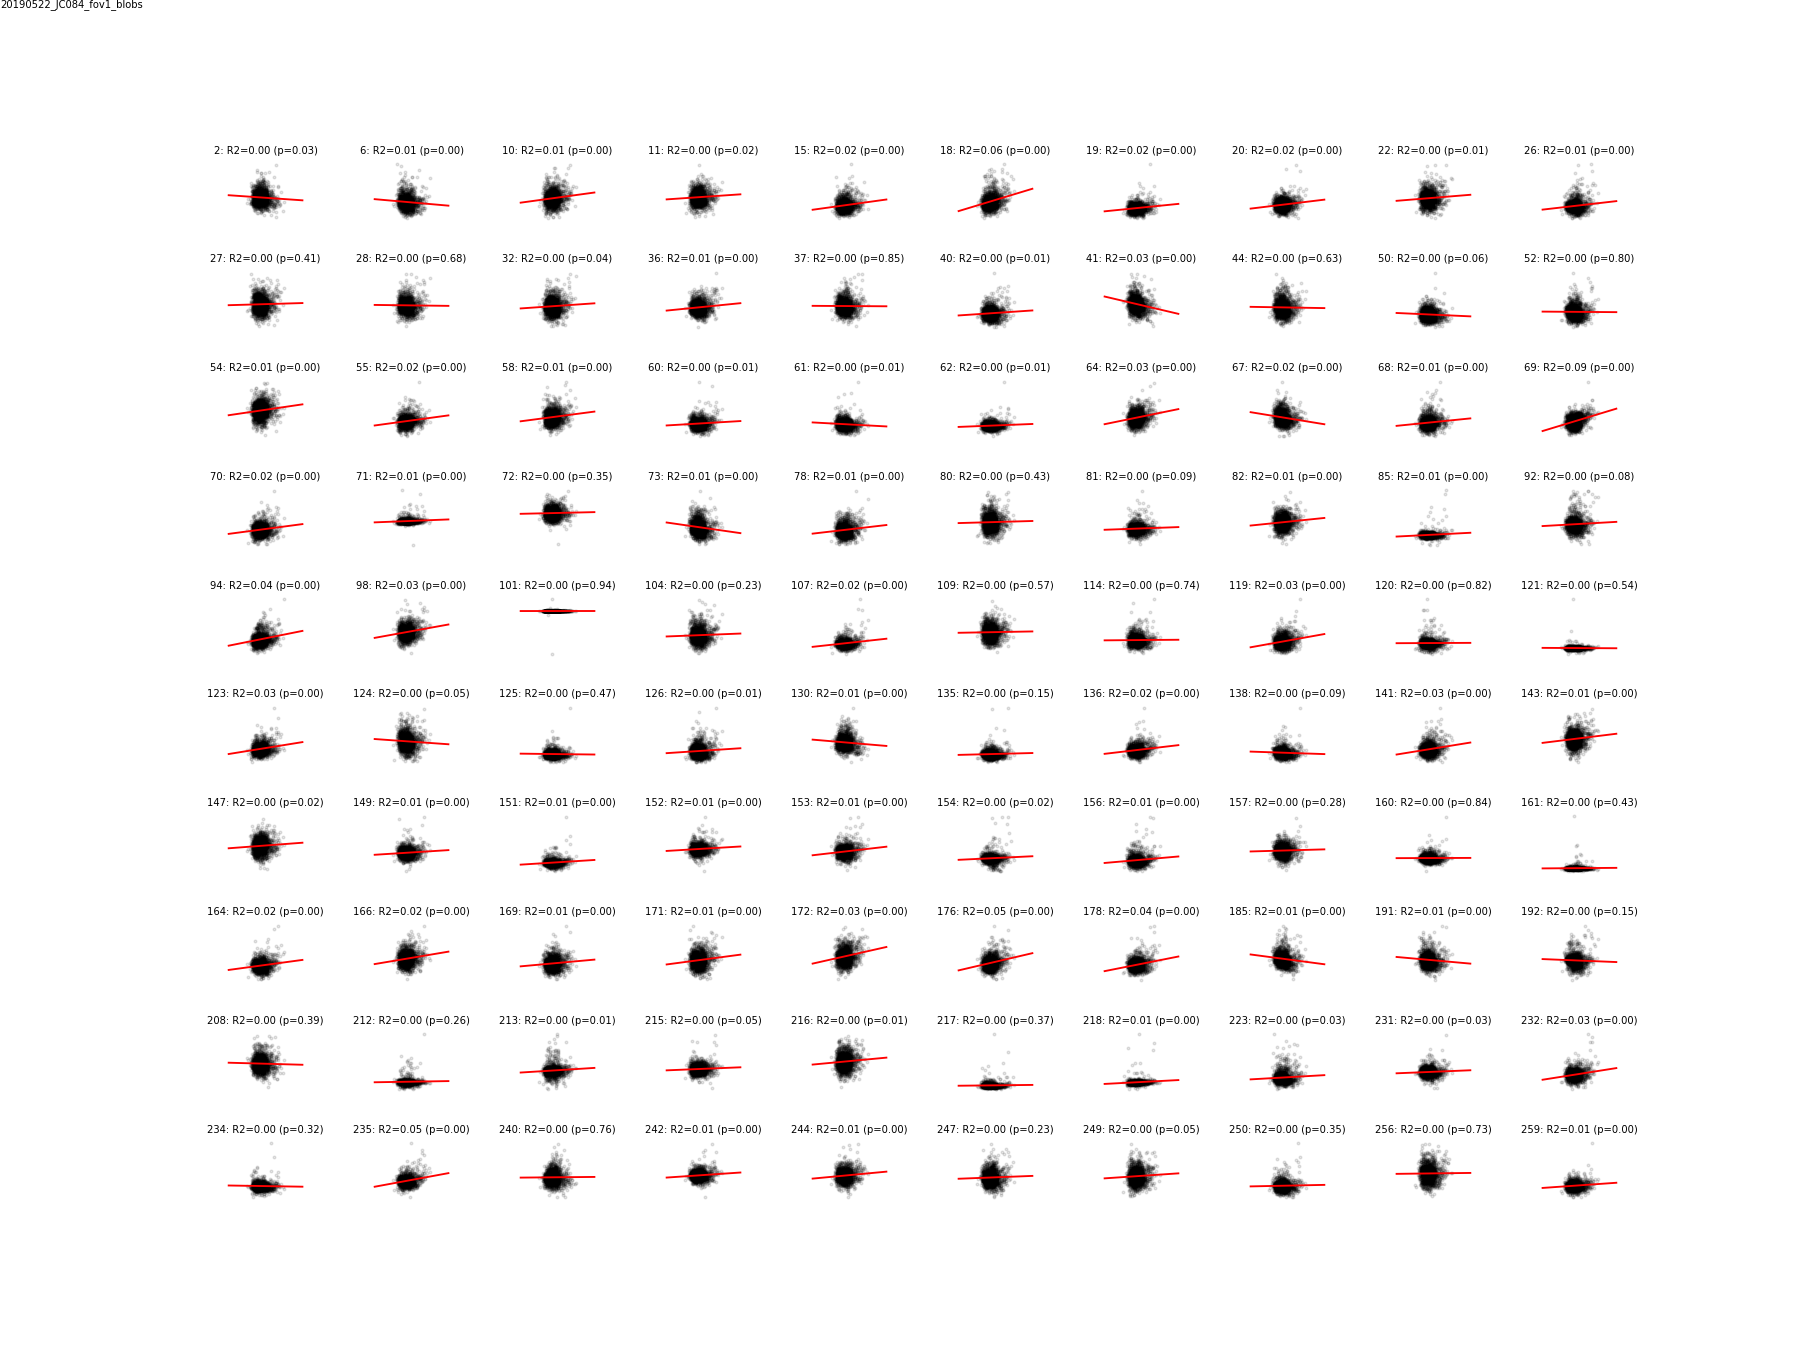

In [695]:
nr = 10
nc = 10

ai = 0
fig, axes = pl.subplots(nr, nc, figsize=(nc*2, nr*1.5))
fig.patch.set_alpha(1)

for rid in responsive_cells:
    ax = axes.flat[ai]
    roi_index = list(responsive_cells).index(rid)
    
    # scatter-plot data
    ax = xdf.plot(x=indepvar_x, y=rid, kind='scatter', alpha=0.1, s=5, c='k', ax=ax)
    #ax.scatter(x_test, y_test,  color='black', alpha=0.5, s=5)

    # generate x-values for your regression line (two is sufficient)
    vmin = xdf[indepvar_x].min()
    vmax = xdf[indepvar_x].max()
    vrange = vmax - vmin
    x = np.linspace(vmin-vrange*.5, vmax+vrange*.5, 3)

    # plot regression line on the same axes, set x-axis limits
    p = ols[rid].params
    ax.plot(x, p.const + p[indepvar_x] * x, color='r')
    #ax.set_xlim([1, 2])

    #modelfit.summary()

    statstr = 'R2=%.2f (p=%.2f)' % (ols[rid].rsquared, ols[rid].f_pvalue)
    #ax.set_title(statstr)

    ax.set_title('%i: %s' % (int(rid+1), statstr), fontsize=8)
    ax.axis('off')

    ai += 1
    
pl.subplots_adjust(hspace=0.8, wspace=0.8)
label_figure(fig, datakey)

[513,
 518,
 519,
 11,
 15,
 530,
 19,
 20,
 22,
 24,
 26,
 28,
 31,
 32,
 34,
 42,
 43,
 48,
 50,
 51,
 54,
 55,
 58,
 59,
 60,
 62,
 65,
 66,
 523,
 69,
 72,
 74,
 75,
 76,
 77,
 85,
 109,
 531,
 126,
 134,
 135,
 137,
 138,
 166,
 169,
 176,
 187,
 196,
 205,
 206,
 209,
 211,
 219,
 234,
 235,
 242,
 243,
 248,
 249,
 251,
 252,
 255,
 256,
 257,
 261,
 266,
 267,
 270,
 272,
 277,
 303,
 304,
 305,
 311,
 316,
 317,
 322,
 326,
 327,
 331,
 332,
 333,
 334,
 341,
 343,
 354,
 362,
 370,
 376,
 378,
 382,
 383,
 387,
 396,
 399,
 401,
 404,
 409,
 414,
 417,
 418,
 429,
 438,
 441,
 447,
 448,
 449,
 453,
 455,
 456,
 457,
 458,
 459,
 464,
 484,
 495,
 496,
 497,
 498,
 499,
 510,
 511]

In [790]:
responsive_cells = ols.keys()
R2 = pd.DataFrame({'R2': [ols[rid].rsquared for rid in responsive_cells],
                   'pval': [ols[rid].f_pvalue for rid in responsive_cells]})
R2['sig'] = [1 if p<0.05 else 0 for p in R2['pval']]
R2['empty'] = [1 for _ in np.arange(0, R2.shape[0])]

<IPython.core.display.Javascript object>


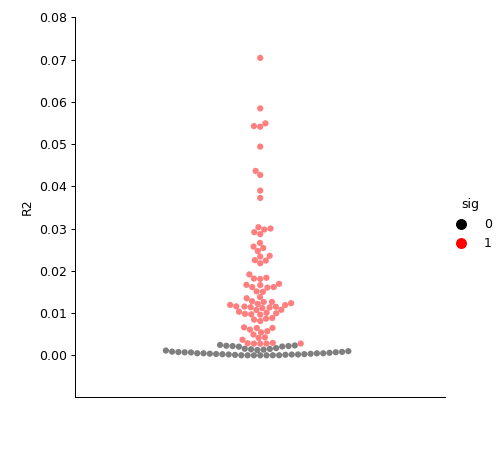

In [791]:

sns.catplot(x='empty', y='R2', kind='swarm', palette=['k', 'r'],
            hue='sig', data=R2, alpha=0.5) #, ax=ax) #color='k', alpha=0.1, ax=ax)
pl.ylabel('R2')
pl.xticks([])
pl.xlabel('')

label_figure(fig, datakey)

# Distribution of R2

In [702]:
R2 = pd.DataFrame({'R2': [ols[rid].rsquared for rid in responsive_cells],
                   'pval': [ols[rid].f_pvalue for rid in responsive_cells]})
R2['sig'] = [1 if p<0.05 else 0 for p in R2['pval']]

In [711]:
R2['empty'] = [1 for _ in np.arange(0, R2.shape[0])]

<IPython.core.display.Javascript object>


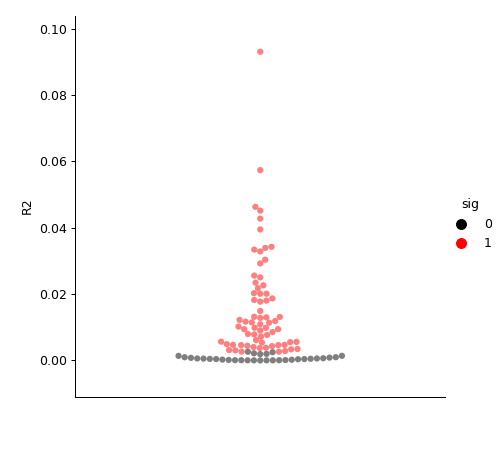

In [716]:

sns.catplot(x='empty', y='R2', kind='swarm', palette=['k', 'r'],
            hue='sig', data=R2, alpha=0.5) #, ax=ax) #color='k', alpha=0.1, ax=ax)
pl.ylabel('R2')
pl.xticks([])
pl.xlabel('')

label_figure(fig, datakey)



<IPython.core.display.Javascript object>


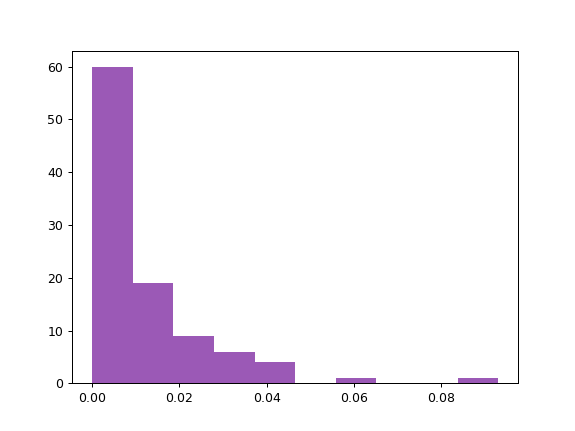

(array([ 60.,  19.,   9.,   6.,   4.,   0.,   1.,   0.,   0.,   1.]),
 array([  4.17311769e-06,   9.31060022e-03,   1.86170273e-02,
          2.79234544e-02,   3.72298815e-02,   4.65363086e-02,
          5.58427357e-02,   6.51491628e-02,   7.44555899e-02,
          8.37620170e-02,   9.30684441e-02]),
 <a list of 10 Patch objects>)

In [717]:
pl.figure()
pl.hist(R2['R2'])